이전 스토리
--

이전 ipynb에서 분석했던 경복궁의 최적 칼럼은 
date,month,평균 기온(°C),최다 풍향(16방위),일강수량(mm),9-9강수(mm),평균 전운량(10분위),합계 소형증발량(mm),최저 해면기압 시각(hhmi),최저 기온 시각(hhmi),열지수 이였다.

한편, 국립중앙박물관의 경우에는 

date, month, 최고 기온(°C),최소 상대습도(%),평균 기온(°C), 평균 상대습도(%),일강수량(mm),평균 풍속(m/s),합계 일조 시간(hr),평균 중기압(hPa),최다 풍향(16방위), 최저 해면기압(hPa),최대 순간풍속 풍향(16방위) 으로 최적 칼럼이 다른 것을 확인 할 수 있었다.

이번 ipynb에서는  관광지별로 칼럼을 맞춰주기 위해 년-월, 월, 최고기온, 최소상대습도, 평균기온, 평균상대습도, 일강수량, 평균 풍속, 합계일조시간 칼럼 부여하고 칼럼을 추가하면서, 최적 칼럼을 찾는 방법(방법1)과

이전 ipynb의 최적 칼럼에서 칼럼을 추가해주면서, 최적 칼럼을 찾는 방법(방법2)를 통해 최적 칼럼을 찾아주고, rmse을 103094 보다 낮추고, test스코어를 0.713이상 높이는 방법을 연구해보도록 한다.

경복궁 2탄 시작
--

In [ ]:
from google.colab import files
files.upload()

In [ ]:
import pandas as pd

seoul=pd.read_csv('seoul.csv')

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [ ]:
seoul['열지수']=0

In [ ]:
# 원래는 기온, 습도으로 해주어야 하나, 여기서는 평균 기온과 평균 습도로 열지수의 평균을 구해주도록 하겠다.

i=0

for i in range(0,108):
    Tc=seoul.loc[i, '평균 기온(°C)']
    T=(Tc*1.8)+32
    R=seoul.loc[i, '평균 상대습도(%)']*1/100
    
    h1= -42.379
    h2=2.04901523*T
    h3=10.14333127*R
    h4=-0.22475541*T*R
    h5=-6.83783*(pow(10, -3))*((pow(T, 2)))
    h6=-5.481717*(pow(10, -2))*(pow(R, 2))
    h7=1.22874*(pow(10,-3))*T*R
    h8=8.5282*(pow(10, -4))*T*(pow(R, 2))
    h9=-1.99*(pow(10, -6))*(pow(T, 2))*(pow(R, 2))
    
    Heat_index=h1+h2+h3+h4+h5+h6+h7+h8+h9
    
    seoul['열지수'][i]=Heat_index
    i+=1

In [ ]:
!pip install catboost

In [ ]:
!pip install lime

In [ ]:
!pip install shap

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error , r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import xgboost as xgb
import lightgbm as lgbm
import scipy
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

In [ ]:
plt.rcParams['font.family'] = 'NanumGothic' 

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf

In [ ]:
import catboost as cb
from lime import lime_tabular
import lime as lime
import sys
sys.path.append('/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/shap-0.26.0-py2.7-macosx-10.9-x86_64.egg')
import shap

In [ ]:
df=seoul[['date','month','평균 기온(°C)','최다 풍향(16방위)','일강수량(mm)','9-9강수(mm)','평균 전운량(10분위)','합계 소형증발량(mm)','최저 해면기압 시각(hhmi)','최저 기온 시각(hhmi)','열지수','경복궁']]

In [ ]:
#df['경복궁']=np.log(df['경복궁']) 

# 원래는 로그변환하면 더 잘나오나 지금은 최적 칼럼을 찾기 위해 쓰지 않음.

In [ ]:
x=df.drop(['경복궁'], axis=1)
y=df['경복궁']

In [ ]:
#s_scaler = StandardScaler()

#s_scaler.fit(x)

# x에 standardscaler를 적용해주면 점수가 올라가나
# 지금은 최적 칼럼을 찾기 위해 쓰지 않음

StandardScaler(copy=True, with_mean=True, with_std=True)

In [ ]:
# s_x_scaled=s_scaler.transform(x)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(s_x_scaled, y, test_size=0.2, random_state=42)

In [ ]:
xgb_reg=xgb.XGBRegressor(random_state=42)
xgb_reg.fit(x_train, y_train)

XGBscore_train = xgb_reg.score(x_train, y_train) # train set 정확도

print('XGboosting train 점수는 {:.3f}'.format(XGBscore_train))

[15:21:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGboosting train 점수는 0.994


In [ ]:
xgb_pred=xgb_reg.predict(x_test)
#xgb_pred=pd.DataFrame(xgb_pred, columns=['xgb_pred'])
#xgb_pred=xgb_pred['xgb_pred'].apply(lambda x: np.exp(x))
#y_test_1=y_test.apply(lambda x: np.exp(x))

rmse=(np.sqrt(mean_squared_error(y_test, xgb_pred)))
r2=round(xgb_reg.score(x_test, y_test), 2)

print('rmse 점수는', format(rmse), '입니다.')
print('r2 점수는', format(r2), '입니다.')
print('test 스코어는', format(xgb_reg.score(x_test, y_test)), '입니다.')

rmse 점수는 100378.71030499725 입니다.
r2 점수는 0.62 입니다.
test 스코어는 0.6173170868583868 입니다.


최적 변수 찾기 방법 1
--

목표: rmse는 100378이하로, test스코어는 0.617이상 만들기

In [ ]:
seoul.columns

Index(['Unnamed: 0', 'date', 'year', 'month', '평균 기온(°C)', '최저 기온(°C)',
       '최저 기온 시각(hhmi)', '최고 기온(°C)', '최고 기온 시각(hhmi)', '1시간 최다강수량 시각(hhmi)',
       '일강수량(mm)', '최대 순간풍속(m/s)', '최대 순간풍속 풍향(16방위)', '최대 순간풍속 시각(hhmi)',
       '최대 풍속(m/s)', '최대 풍속 풍향(16방위)', '최대 풍속 시각(hhmi)', '평균 풍속(m/s)',
       '풍정합(100m)', '최다 풍향(16방위)', '평균 이슬점온도(°C)', '최소 상대습도(%)',
       '평균 상대습도 시각(hhmi)', '평균 상대습도(%)', '평균 중기압(hPa)', '평균 현지기압(hPa)',
       '최고 해면 기압(hPa)', '최고 해면기압 시각(hhmi)', '최저 해면기압(hPa)', '최저 해면기압 시각(hhmi)',
       '평균 해면기압(hPa)', '가조시간(hr)', '합계 일조 시간(hr)', '1시간 최다 일사 시각(hhmi)',
       '1시간 최다 일사량(MJ/m2)', '합계 일사량(MJ/m2)', '평균 전운량(10분위)', '평균 중하층운량(10분위)',
       '평균 지면온도(°C)', '최저 초상온도(°C)', '평균 5cm 지중온도(°C)', '평균 10cm 지중온도(°C)',
       '평균 20cm 지중온도(°C)', '평균 30cm 지중온도(°C)', '0.5m 지중온도(°C)',
       '1.0cm 지중온도(°C)', '1.5cm 지중온도(°C)', '3.0cm 지중온도(°C)', '5.0cm 지중온도(°C)',
       '합계 소형증발량(mm)', '9-9강수(mm)', '경복궁', '종묘', '창경궁', '창덕궁', '남산골한옥마을',
       '덕수궁', '서울시립미술관 본관', '국립중앙박물관', '태릉

In [ ]:
len(t1.columns.unique())

51

In [ ]:
df_seoul=seoul[['date','month','평균 기온(°C)','최다 풍향(16방위)','일강수량(mm)','9-9강수(mm)','평균 전운량(10분위)',
          '합계 소형증발량(mm)','최저 해면기압 시각(hhmi)','최저 기온 시각(hhmi)','열지수',
           '평균 10cm 지중온도(°C)','평균 상대습도(%)','최대 순간풍속 시각(hhmi)','최소 상대습도(%)',
           '합계 일조 시간(hr)','풍정합(100m)','최고 기온 시각(hhmi)', '평균 20cm 지중온도(°C)',
           '합계 일사량(MJ/m2)',
          
          
          
          '평균 상대습도 시각(hhmi)',
          '최대 풍속 풍향(16방위)', '최저 기온(°C)',  '최고 기온(°C)',
           '최고 해면기압 시각(hhmi)','1시간 최다 일사량(MJ/m2)',
          
          'year',  
        '1시간 최다강수량 시각(hhmi)', '최대 순간풍속(m/s)', '최대 순간풍속 풍향(16방위)',
       '최대 풍속(m/s)', '최대 풍속 시각(hhmi)', '평균 풍속(m/s)',
        '평균 이슬점온도(°C)', 
        '평균 중기압(hPa)', '평균 현지기압(hPa)',
       '최고 해면 기압(hPa)', '최저 해면기압(hPa)', 
       '평균 해면기압(hPa)', '가조시간(hr)',  '1시간 최다 일사 시각(hhmi)',
          '평균 중하층운량(10분위)',
       '평균 지면온도(°C)', '최저 초상온도(°C)', '평균 5cm 지중온도(°C)', 
       '평균 30cm 지중온도(°C)', '0.5m 지중온도(°C)',
       '1.0cm 지중온도(°C)', '1.5cm 지중온도(°C)', '3.0cm 지중온도(°C)', '5.0cm 지중온도(°C)']]

In [ ]:
x=df_seoul.copy()
y=seoul['경복궁']

In [ ]:
def feature_choice(df):
    xgb_reg=xgb.XGBRegressor(random_state=42)
    data=pd.DataFrame(columns=['변수','rmse','test_score'])

    for i in range(21,50):
        x1=df_seoul.iloc[:, :20]
        x2=df_seoul.iloc[:, i]
        x=pd.concat([x1,x2], axis=1)
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
        xgb_reg.fit(x_train, y_train)
        XGBscore_train = xgb_reg.score(x_train, y_train) 
        xgb_pred=xgb_reg.predict(x_test)
        rmse=(np.sqrt(mean_squared_error(y_test, xgb_pred)))
        test_score=xgb_reg.score(x_test, y_test)

        data=data.append({'변수':i, 'rmse':rmse, 'test_score':test_score}, ignore_index=True)
        i+1
    data=data.sort_values('test_score', ascending=False)
    data_2=data.head()

    return data_2

In [ ]:
feature_choice(df_seoul)

[17:04:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:04:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:04:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:04:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:04:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:04:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:04:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:04:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

,변수,rmse,test_score
5,26.0,86256.295482,0.717423
11,32.0,86367.825779,0.716691
7,28.0,86780.749847,0.713976
1,22.0,87328.057614,0.710357
6,27.0,88101.217929,0.705205


In [ ]:
df_seoul.iloc[:, 26]

0      2011
1      2011
2      2011
3      2011
4      2011
       ... 
103    2019
104    2019
105    2019
106    2019
107    2019
Name: year, Length: 108, dtype: int64

목표: rmse는 100378이하로, test스코어는 0.617이상 만들기

평균 10cm 지중온도(°C)을 추가해준 결과: rmse: 95855.08398 test_score: 0.651032

 평균 상대습도(%)를 추가해준 결과: rmse: 93567.425900 test_score: 0.667490

 최대 순간풍속 시각(hhmi)를 추가해준 결과: rmse: 92338.427751	 test_score: 0.676167

 최소 상대습도(%)를 추가해준 결과: rmse: 91232.855277, test_score: 0.683875

 합계 일조 시간을 추가해준 결과: rmse: 90981.060593 test_score: 0.685618

 풍정합(100m)를 추가해준 결과: rmse: 88870.632992 test_score: 0.700034

 최고 기온 시각(hhmi)를 추가해준 결과: rmse: 88207.242419, test_score: 0.704495

 평균 20cm 지중온도(°C)를 추가해준 결과: rmse: 86412.768614  test_score:0.716396

 합계 일사량(MJ/m2)를 추가해준 결과: rmse:86256.295482 test_score: 0.717423

 더 이상 올라가지 않으므로 여기서 마무리



로그변환과 standard scaler 적용
--

In [ ]:
df_seoul=seoul[['date','month','평균 기온(°C)','최다 풍향(16방위)','일강수량(mm)','9-9강수(mm)','평균 전운량(10분위)',
          '합계 소형증발량(mm)','최저 해면기압 시각(hhmi)','최저 기온 시각(hhmi)','열지수',
           '평균 10cm 지중온도(°C)','평균 상대습도(%)','최대 순간풍속 시각(hhmi)','최소 상대습도(%)',
           '합계 일조 시간(hr)','풍정합(100m)','최고 기온 시각(hhmi)', '평균 20cm 지중온도(°C)',
           '합계 일사량(MJ/m2)','경복궁']]

In [ ]:
df_seoul['경복궁']=np.log(df_seoul['경복궁']) 

In [ ]:
x=df_seoul.drop(['경복궁'], axis=1)
y=df_seoul['경복궁']

In [ ]:
s_scaler = StandardScaler()

s_scaler.fit(x)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [ ]:
s_x_scaled=s_scaler.transform(x)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(s_x_scaled, y, test_size=0.2, random_state=42)

In [ ]:
xgb_reg=xgb.XGBRegressor(random_state=42)
xgb_reg.fit(x_train, y_train)

XGBscore_train = xgb_reg.score(x_train, y_train) # train set 정확도

print('XGboosting train 점수는 {:.3f}'.format(XGBscore_train))

[17:05:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGboosting train 점수는 0.993


In [ ]:
xgb_pred=xgb_reg.predict(x_test)
xgb_pred=pd.DataFrame(xgb_pred, columns=['xgb_pred'])
xgb_pred=xgb_pred['xgb_pred'].apply(lambda x: np.exp(x))
y_test_1=y_test.apply(lambda x: np.exp(x))

rmse=(np.sqrt(mean_squared_error(y_test_1, xgb_pred)))
r2=round(xgb_reg.score(x_test, y_test), 2)

print('rmse 점수는', format(rmse), '입니다.')
print('r2 점수는', format(r2), '입니다.')
print('test 스코어는', format(xgb_reg.score(x_test, y_test)), '입니다.')

rmse 점수는 100696.67973290347 입니다.
r2 점수는 0.74 입니다.
test 스코어는 0.7414096292759185 입니다.


로그변환과 scaler 적용하지 않기

In [ ]:
df_seoul=seoul[['date','month','평균 기온(°C)','최다 풍향(16방위)','일강수량(mm)','9-9강수(mm)','평균 전운량(10분위)',
          '합계 소형증발량(mm)','최저 해면기압 시각(hhmi)','최저 기온 시각(hhmi)','열지수',
           '평균 10cm 지중온도(°C)','평균 상대습도(%)','최대 순간풍속 시각(hhmi)','최소 상대습도(%)',
           '합계 일조 시간(hr)','풍정합(100m)','최고 기온 시각(hhmi)', '평균 20cm 지중온도(°C)',
           '합계 일사량(MJ/m2)','경복궁']]

In [ ]:
x=df_seoul.drop(['경복궁'], axis=1)
y=df_seoul['경복궁']

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
xgb_reg=xgb.XGBRegressor(random_state=42)
xgb_reg.fit(x_train, y_train)

XGBscore_train = xgb_reg.score(x_train, y_train) # train set 정확도

print('XGboosting train 점수는 {:.3f}'.format(XGBscore_train))

[17:06:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGboosting train 점수는 0.997


In [ ]:
xgb_pred=xgb_reg.predict(x_test)
#xgb_pred=pd.DataFrame(xgb_pred, columns=['xgb_pred'])
#xgb_pred=xgb_pred['xgb_pred'].apply(lambda x: np.exp(x))
#y_test_1=y_test.apply(lambda x: np.exp(x))

rmse=(np.sqrt(mean_squared_error(y_test, xgb_pred)))
r2=round(xgb_reg.score(x_test, y_test), 2)

print('rmse 점수는', format(rmse), '입니다.')
print('r2 점수는', format(r2), '입니다.')
print('test 스코어는', format(xgb_reg.score(x_test, y_test)), '입니다.')

rmse 점수는 86256.29548151133 입니다.
r2 점수는 0.72 입니다.
test 스코어는 0.717422581763773 입니다.


rmse를 기준으로 하면 scaler와 로그변환을 안 하는 것이 낫고, 

test_score(r2)를 기준으로 하면, scaler와 로그변환을 하는 것이 낫다.

sclaer와 로그변환 적용 후에 random_state 다르게 적용해주기
--

In [ ]:
df_seoul=seoul[['date','month','평균 기온(°C)','최다 풍향(16방위)','일강수량(mm)','9-9강수(mm)','평균 전운량(10분위)',
          '합계 소형증발량(mm)','최저 해면기압 시각(hhmi)','최저 기온 시각(hhmi)','열지수',
           '평균 10cm 지중온도(°C)','평균 상대습도(%)','최대 순간풍속 시각(hhmi)','최소 상대습도(%)',
           '합계 일조 시간(hr)','풍정합(100m)','최고 기온 시각(hhmi)', '평균 20cm 지중온도(°C)',
           '합계 일사량(MJ/m2)','경복궁']]

In [ ]:
df_seoul['경복궁']=np.log(df_seoul['경복궁']) 

In [ ]:
x=df_seoul.drop(['경복궁'], axis=1)
y=df_seoul['경복궁']

In [ ]:
s_scaler = StandardScaler()

s_scaler.fit(x)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [ ]:
s_x_scaled=s_scaler.transform(x)

In [ ]:
i=0
df_xgb=pd.DataFrame(columns=['num','rmse','test_score'])

for i in range(0,100000):
    x_train, x_test, y_train, y_test = train_test_split(s_x_scaled, y, test_size=0.2, random_state=i)
    xgb_reg=xgb.XGBRegressor(random_state=i)
    xgb_reg.fit(x_train, y_train)
    XGBscore_train = xgb_reg.score(x_train, y_train)

    xgb_reg=xgb.XGBRegressor(random_state=i)
    xgb_reg.fit(x_train, y_train)
    
    XGBscore_train = xgb_reg.score(x_train, y_train)

    xgb_pred=xgb_reg.predict(x_test)
    xgb_pred=pd.DataFrame(xgb_pred, columns=['xgb_pred'])
    xgb_pred=xgb_pred['xgb_pred'].apply(lambda x: np.exp(x))
    y_test_1=y_test.apply(lambda x: np.exp(x))
    rmse=(np.sqrt(mean_squared_error(y_test_1, xgb_pred)))
    test_score=xgb_reg.score(x_test, y_test)
            
    df_xgb=df_xgb.append({'num':i, 'rmse':rmse, 'test_score':test_score}, ignore_index=True)
    i+1


df_xgb=df_xgb.sort_values('test_score', ascending=False)
df_xgb=df_xgb.head()

In [ ]:
df_xgb # 0~99999까지 random_state 숫자 설정 후 결과

,num,rmse,test_score
32184,32184.0,27751.052080,0.916157
42894,42894.0,43870.983199,0.915588
99491,99491.0,33639.805526,0.910565
54500,54500.0,33345.513359,0.907285
2498,2498.0,45327.305419,0.904889


In [ ]:
df_xgb # 0~9999까지 random_state 숫자 설정 후 결과

,num,rmse,test_score
2498,2498.0,45327.305419,0.904889
8851,8851.0,32997.458836,0.885487
8842,8842.0,52922.196238,0.881590
3257,3257.0,44562.748006,0.881176
5215,5215.0,43063.636806,0.875878


random_state 0-999 까지 시행

- random_state는 351일 때, rmse가 41571.276251, test_score가 0.859487 까지 올라간다.

random_state 0-9999까지 시행

- random_state가 2498일 때, rmse는 45327.305473, test_score는 0.904889가 나오며,

- random_state가 8851일 때, rmse는 32997.458836, test_score는 0.885487이 나온다.

random_state 0-99999 까지 시행
- random_state가 32184일 때, rmse는 27751.052080, test_score는 0.916157이 나온다.

- random_state를 다르게 줬을 때, 점수가 올라간다고 생각해서, 0부터 99999까지 다르게 주고 결과를 돌렸을 때, test점수가 올라갔음.

- 그러나, 실제로 캐글문제 하나를 타겟으로 잡고 실제 제출로 실험해본 결과, train, test를 나눠서 random_state를 다르게 부여했을 때, test점수가 올라갔으나, 실제 제출에서는 점수가 전부 똑같았음. 

- 따라서, random_state으로 인해 점수가 올라가는 것은 신뢰가 어렵다고 판단

변수와 모델 해석하기
--

In [ ]:
x=df_seoul.drop(['경복궁'], axis=1)
y=df_seoul['경복궁']

In [ ]:
# 변수들에 상수항을 추가함
x_constant=sm.add_constant(x)

model_1=sm.OLS(y,x_constant)
lin_reg=model_1.fit()
lin_reg.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    경복궁   R-squared:                       0.579
Model:                            OLS   Adj. R-squared:                  0.482
Method:                 Least Squares   F-statistic:                     5.974
Date:                Wed, 07 Jul 2021   Prob (F-statistic):           1.61e-09
Time:                        00:21:48   Log-Likelihood:                -1373.2
No. Observations:                 108   AIC:                             2788.
Df Residuals:                      87   BIC:                             2845.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             2.603e+06   1.35e+07      0.193      0.847   -2.42e+07    2.94e+07
date               -10.7896     67.100     -0.161      0.873    -144.158     122.578
month            -5566.6027   4721.208     -1.179      0.242    -1.5e+04    3817.310
평균 기온(°C)        -8.064e+04    2.2e+04     -3.663      0.000   -1.24e+05   -3.69e+04
최다 풍향(16방위)          2.3389    329.953      0.007      0.994    -653.478     658.156
일강수량(mm)          -448.3025   7386.958     -0.061      0.952   -1.51e+04    1.42e+04
9-9강수(mm)         -648.2730   7675.577     -0.084      0.933   -1.59e+04    1.46e+04
평균 전운량(10분위)     -3.138e+04   2.42e+04     -1.296      0.198   -7.95e+04    1.67e+04
합계 소형증발량(mm)      -3.29e+04   2.08e+04     -1.583      0.117   -7.42e+04    8413.454
최저 해면기압 시각(hhmi)    77.0714    100.195      0.769      0.444    -122.076     276.219
최저 기온 시각(hhmi)      75.1970     96.261      0.781      0.437    -116.133     266.527
열지수                3.16e+04   6781.145      4.660      0.000    1.81e+04    4.51e+04
평균 10cm 지중온도(°C)  6.702e+04   5.27e+04      1.273      0.207   -3.76e+04    1.72e+05
평균 상대습도(%)         350.0265   6339.693      0.055      0.956   -1.23e+04     1.3e+04
최대 순간풍속 시각(hhmi)  -128.2532    120.954     -1.060      0.292    -368.662     112.156
최소 상대습도(%)       -5055.3583   6246.854     -0.809      0.421   -1.75e+04    7360.940
합계 일조 시간(hr)     -1.032e+04   2.16e+04     -0.478      0.634   -5.32e+04    3.26e+04
풍정합(100m)          -54.2364     40.479     -1.340      0.184    -134.693      26.221
최고 기온 시각(hhmi)    -152.5485    148.763     -1.025      0.308    -448.230     143.133
평균 20cm 지중온도(°C) -3.702e+04    4.7e+04     -0.787      0.433   -1.31e+05    5.65e+04
합계 일사량(MJ/m2)    -6667.4482   8503.926     -0.784      0.435   -2.36e+04    1.02e+04
==============================================================================
Omnibus:                       21.769   Durbin-Watson:                   2.267
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.820
Skew:                           0.804   Prob(JB):                     5.03e-10
Kurtosis:                       5.633   Cond. No.                     3.14e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.14e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
p_values_1=pd.DataFrame(lin_reg.pvalues, columns=['p-value'])
p_values_1=p_values_1.sort_values(by='p-value', ascending=True)
p_values_1.loc[p_values_1['p-value']<0.05] 

,p-value
열지수,0.000011
평균 기온(°C),0.000427


In [ ]:
p_values_1

,p-value
열지수,0.000011
평균 기온(°C),0.000427
합계 소형증발량(mm),0.117083
풍정합(100m),0.183782
평균 전운량(10분위),0.198244
평균 10cm 지중온도(°C),0.206522
month,0.241588
최대 순간풍속 시각(hhmi),0.291921
최고 기온 시각(hhmi),0.307994
최소 상대습도(%),0.420571


- 최다 풍향과 평균 상대습도, 일강수량이 p-value가 가장 높다.

- 열지수, 평균기온, 힙계 소형 증발량이 p-value가 가장 낮다.

In [ ]:
vif = pd.DataFrame()
vif['VIF Factor']=[variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
vif['features']=x.columns
vif=vif.sort_values(by='VIF Factor', ascending=True)

In [ ]:
vif.loc[vif['VIF Factor']<10]

,VIF Factor,features


In [ ]:
vif

,VIF Factor,features
1,16.043970,month
16,39.141454,풍정합(100m)
3,48.508423,최다 풍향(16방위)
4,78.217600,일강수량(mm)
7,80.406004,합계 소형증발량(mm)
5,82.628215,9-9강수(mm)
9,101.647897,최저 기온 시각(hhmi)
6,168.551870,평균 전운량(10분위)
19,171.645853,합계 일사량(MJ/m2)
8,217.124952,최저 해면기압 시각(hhmi)


- date와 평균 10cm, 20cm 지중온도가 vif가 가장 높다.

- month, 풍정합, 최다풍향(16방위)가 vif가 가장 낮다.

shap로 해석해보기
--

In [ ]:
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=32184)

In [ ]:
xgb_reg=xgb.XGBRegressor(random_state=32184)
xgb_reg.fit(x_train, y_train)
XGBscore_train = xgb_reg.score(x_train, y_train)

[01:28:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
xgb_pred=xgb_reg.predict(x_test)
#xgb_pred=pd.DataFrame(xgb_pred, columns=['xgb_pred'])
#xgb_pred=xgb_pred['xgb_pred'].apply(lambda x: np.exp(x))
#y_test_1=y_test.apply(lambda x: np.exp(x))
rmse=(np.sqrt(mean_squared_error(y_test, xgb_pred)))
test_score=xgb_reg.score(x_test, y_test)
print('rmse:', rmse)
print('test_score: ', test_score)

rmse: 38632.51853072644
test_score:  0.8672751353412139


In [ ]:
explainer = shap.TreeExplainer(xgb_reg)
shap_values = explainer.shap_values(x)

In [ ]:
shap.initjs()

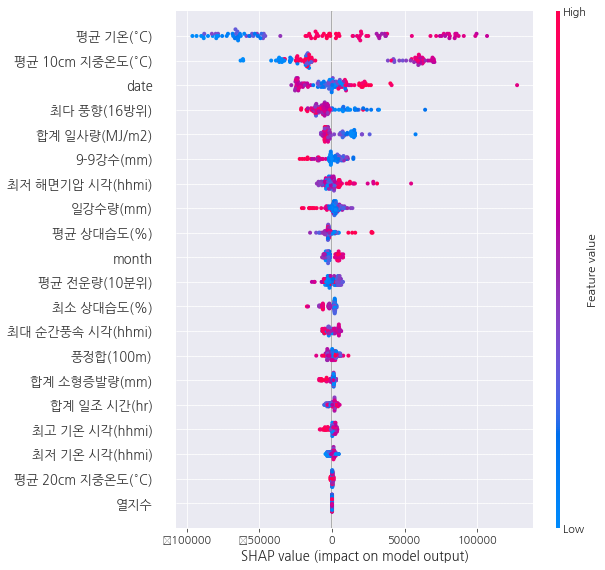

In [ ]:
plt.rcParams['font.family'] = 'NanumGothic' 
shap.summary_plot(shap_values, x)

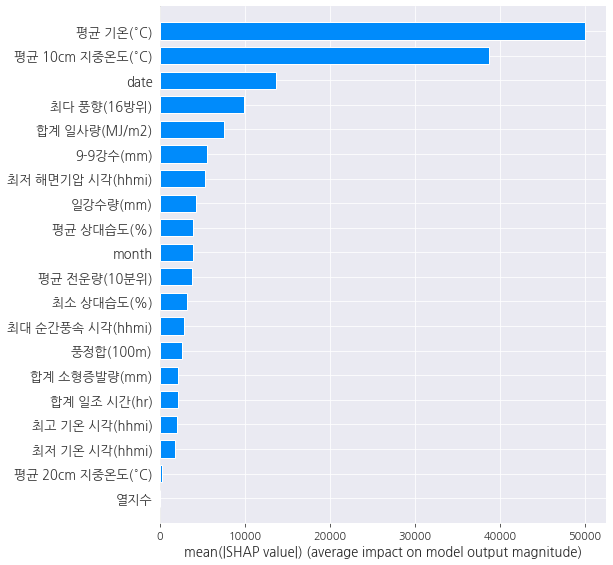

In [ ]:
shap_values = shap.TreeExplainer(xgb_reg).shap_values(x)
shap.summary_plot(shap_values, x, plot_type="bar")

In [ ]:
x_test.head() # 실제 테스트지 앞부분 5개

,date,month,평균 기온(°C),최다 풍향(16방위),일강수량(mm),9-9강수(mm),평균 전운량(10분위),합계 소형증발량(mm),최저 해면기압 시각(hhmi),최저 기온 시각(hhmi),열지수,평균 10cm 지중온도(°C),평균 상대습도(%),최대 순간풍속 시각(hhmi),최소 상대습도(%),합계 일조 시간(hr),풍정합(100m),최고 기온 시각(hhmi),평균 20cm 지중온도(°C),합계 일사량(MJ/m2)
13,201202,2,-2.044828,201.724138,0.133333,0.200000,3.400000,2.703448,1341.551724,1023.931034,11,-0.762069,43.179310,1334.931034,23.620690,7.755172,2468.413793,1378.034483,-0.717241,11.215517
22,201211,11,5.540000,182.000000,4.520000,4.520000,4.536667,1.900000,1137.966667,1148.633333,32,6.390000,57.240000,1274.000000,36.833333,6.036667,2340.133333,1319.800000,7.340000,7.619667
84,201801,1,-3.977419,257.741935,0.772727,0.850000,4.254839,1.264516,1184.290323,1165.193548,6,-0.938710,48.032258,1260.064516,28.935484,6.437931,1618.387097,1381.000000,0.070968,5.482414
25,201302,2,-1.239286,220.357143,5.700000,5.327273,4.717857,1.739286,1192.535714,1224.392857,14,-0.342857,53.628571,1250.464286,30.285714,6.685714,2494.428571,1226.750000,-0.135714,10.588571
95,201812,12,-0.606452,211.935484,2.733333,1.822222,3.770968,1.822581,1186.903226,1035.161290,15,1.712903,45.758065,1248.709677,26.483871,6.448387,1561.129032,1329.161290,2.841935,8.181935


201202

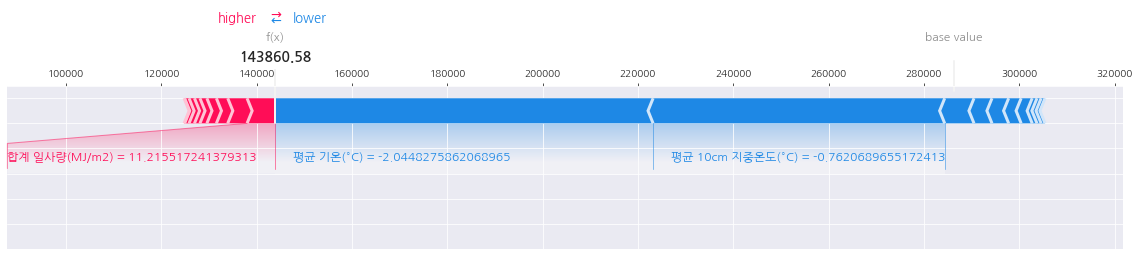

In [ ]:
shap_display=shap.force_plot(explainer.expected_value, shap_values[0, :], x.iloc[13, :], matplotlib=True)

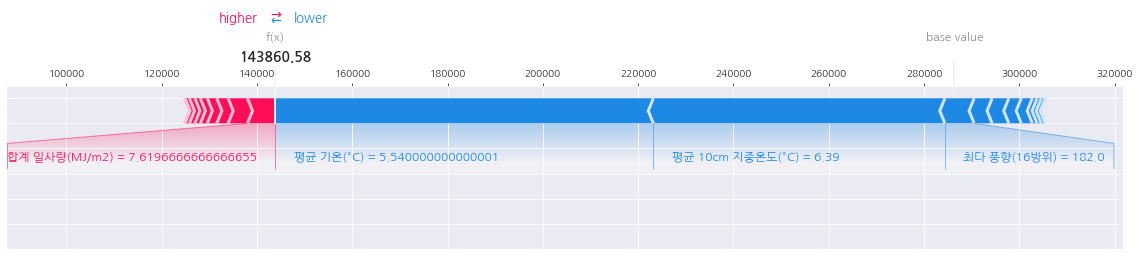

In [ ]:
shap_display=shap.force_plot(explainer.expected_value, shap_values[0, :], x.iloc[22, :], matplotlib=True)

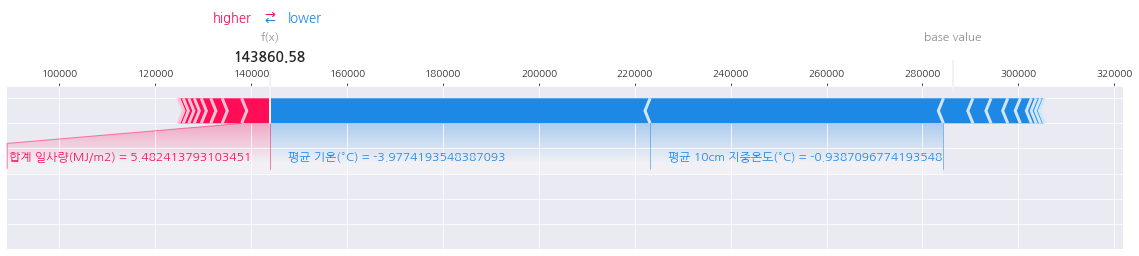

In [ ]:
shap_display=shap.force_plot(explainer.expected_value, shap_values[0, :], x.iloc[84, :], matplotlib=True)

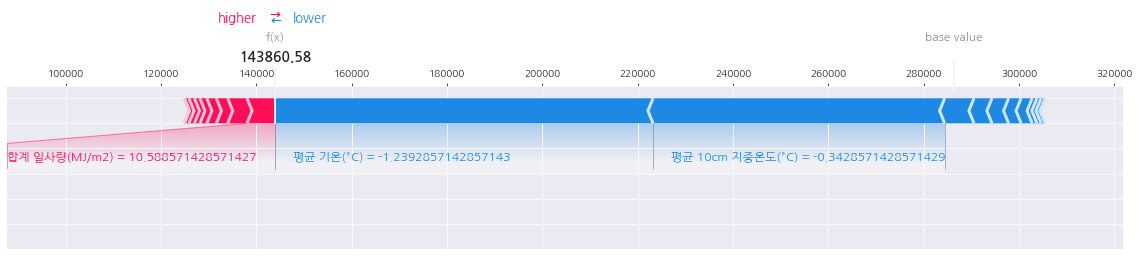

In [ ]:
shap_display=shap.force_plot(explainer.expected_value, shap_values[0, :], x.iloc[25, :], matplotlib=True)

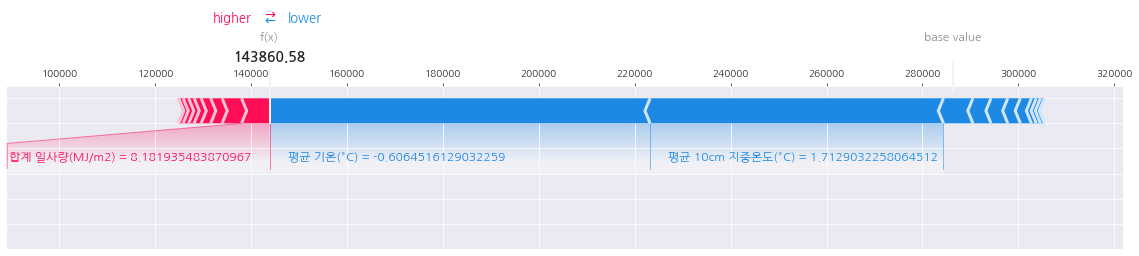

In [ ]:
shap_display=shap.force_plot(explainer.expected_value, shap_values[0, :], x.iloc[95, :], matplotlib=True)

평균기온과 평균 10cm 지중온도를 점검할 필요가 있을 것 같다.

최다 풍향과 평균 상대습도, 일강수량이 p-value가 가장 높다.

열지수, 평균기온, 힙계 소형 증발량이 p-value가 가장 낮다.

date와 평균 10cm, 20cm 지중온도가 vif가 가장 높다.

month, 풍정합, 최다풍향(16방위)가 vif가 가장 낮다.

최다 풍향

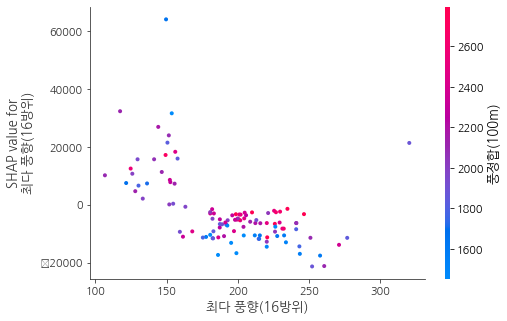

In [ ]:
shap.dependence_plot('최다 풍향(16방위)', shap_values, x)

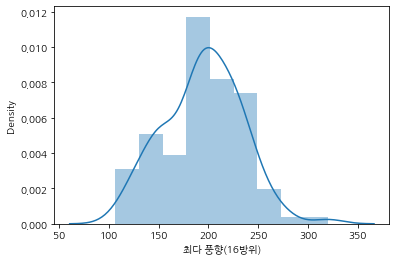

In [ ]:
plt.rcParams['font.family'] = 'NanumGothic' 
sns.distplot(df_seoul['최다 풍향(16방위)'])

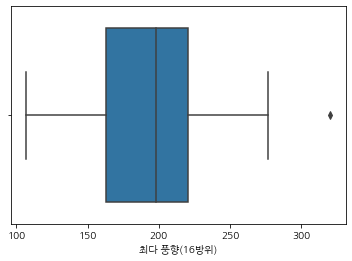

In [ ]:
plt.rcParams['font.family'] = 'NanumGothic'
sns.boxplot(x = '최다 풍향(16방위)', orient = "v", data = df_seoul)
sns.set_style("darkgrid")
plt.show()

평균 상대습도

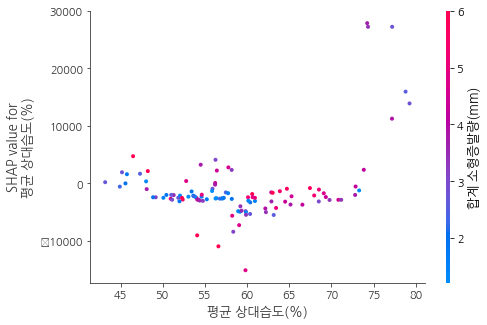

In [ ]:
shap.dependence_plot('평균 상대습도(%)', shap_values, x)

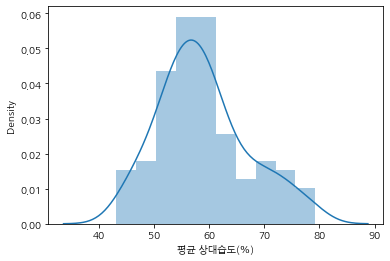

In [ ]:
plt.rcParams['font.family'] = 'NanumGothic' 
sns.distplot(df_seoul['평균 상대습도(%)'])

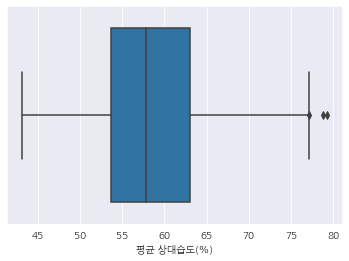

In [ ]:
plt.rcParams['font.family'] = 'NanumGothic'
sns.boxplot(x = '평균 상대습도(%)', orient = "v", data = df_seoul)
sns.set_style("darkgrid")
plt.show()

일강수량

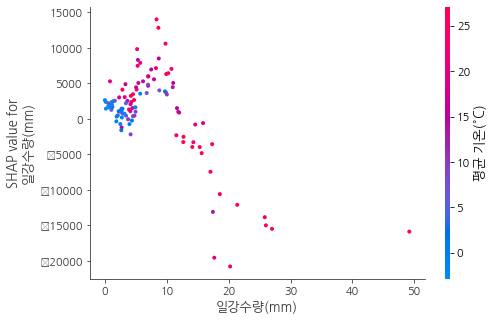

In [ ]:
shap.dependence_plot('일강수량(mm)', shap_values, x)

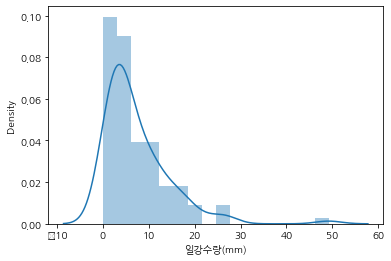

In [ ]:
plt.rcParams['font.family'] = 'NanumGothic' 
sns.distplot(df_seoul['일강수량(mm)'])

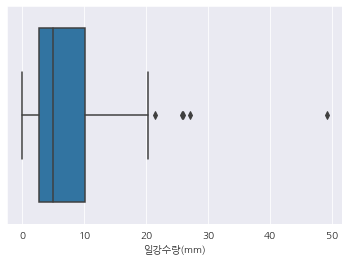

In [ ]:
plt.rcParams['font.family'] = 'NanumGothic'
sns.boxplot(x = '일강수량(mm)', orient = "v", data = df_seoul)
sns.set_style("darkgrid")
plt.show()

date

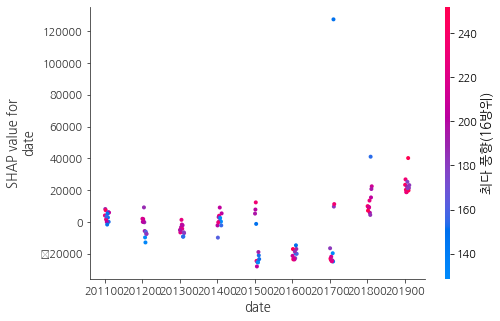

In [ ]:
shap.dependence_plot('date', shap_values, x)

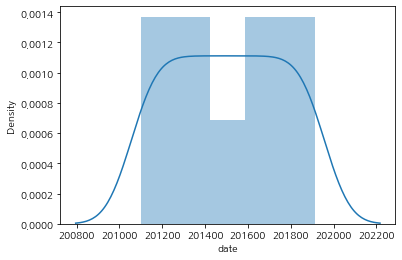

In [ ]:
plt.rcParams['font.family'] = 'NanumGothic' 
sns.distplot(df_seoul['date'])

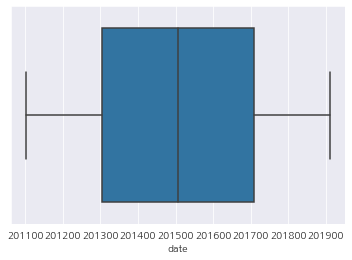

In [ ]:
plt.rcParams['font.family'] = 'NanumGothic'
sns.boxplot(x = 'date', orient = "v", data = df_seoul)
sns.set_style("darkgrid")
plt.show()

평균 10cm 지중온도

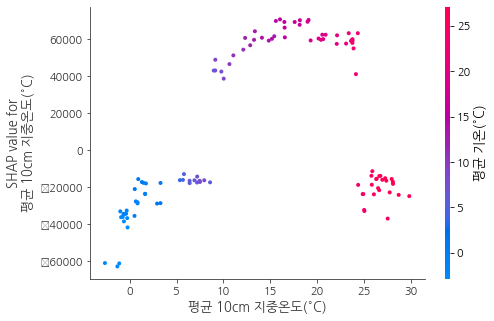

In [ ]:
shap.dependence_plot('평균 10cm 지중온도(°C)', shap_values, x)

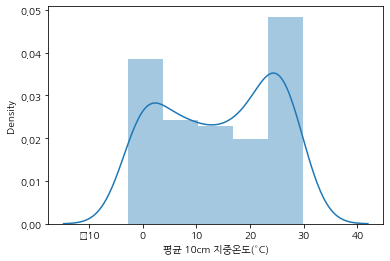

In [ ]:
plt.rcParams['font.family'] = 'NanumGothic' 
sns.distplot(df_seoul['평균 10cm 지중온도(°C)'])

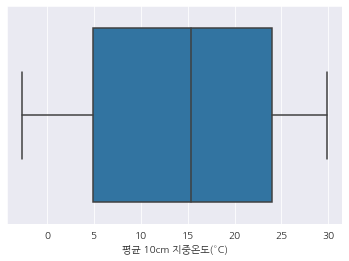

In [ ]:
plt.rcParams['font.family'] = 'NanumGothic'
sns.boxplot(x = '평균 10cm 지중온도(°C)', orient = "v", data = df_seoul)
sns.set_style("darkgrid")
plt.show()

평균 20cm 지중온도

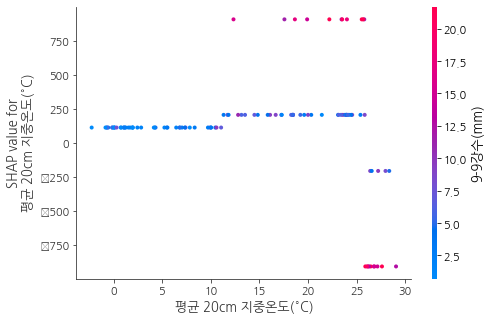

In [ ]:
shap.dependence_plot('평균 20cm 지중온도(°C)', shap_values, x)

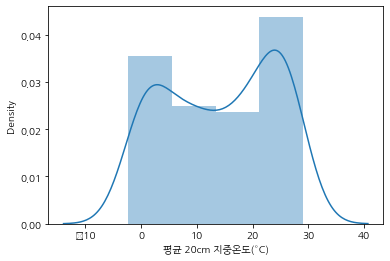

In [ ]:
plt.rcParams['font.family'] = 'NanumGothic' 
sns.distplot(df_seoul['평균 20cm 지중온도(°C)'])

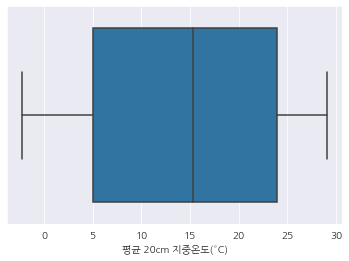

In [ ]:
plt.rcParams['font.family'] = 'NanumGothic'
sns.boxplot(x = '평균 20cm 지중온도(°C)', orient = "v", data = df_seoul)
sns.set_style("darkgrid")
plt.show()

평균 기온

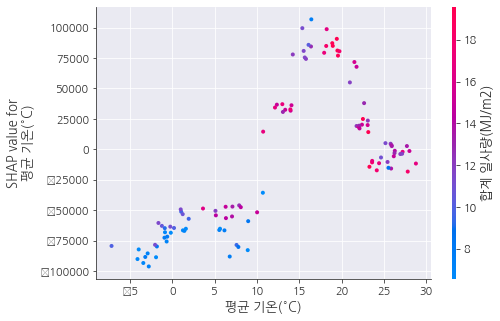

In [ ]:
shap.dependence_plot('평균 기온(°C)', shap_values, x)

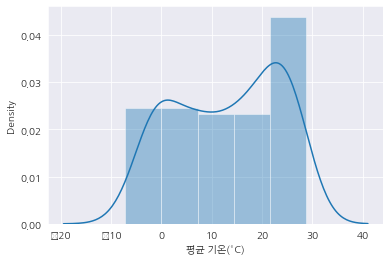

In [ ]:
plt.rcParams['font.family'] = 'NanumGothic' 
sns.distplot(df_seoul['평균 기온(°C)'])

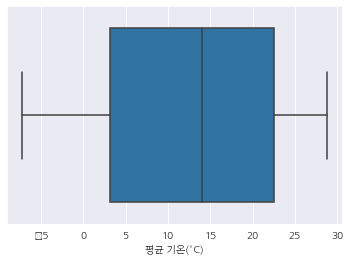

In [ ]:
plt.rcParams['font.family'] = 'NanumGothic'
sns.boxplot(x = '평균 기온(°C)', orient = "v", data = df_seoul)
sns.set_style("darkgrid")
plt.show()

Lime으로 해석해보기
--

In [ ]:
reg_all=LinearRegression()
reg_all.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
y_train_pred=reg_all.predict(x_train)

rmse=(np.sqrt(mean_squared_error(y_train, y_train_pred)))
r2=round(reg_all.score(x_train, y_train), 2)

y_test_pred=reg_all.predict(x_test)

rmse_te=(np.sqrt(mean_squared_error(y_test, y_test_pred)))
r2_te=round(reg_all.score(x_test, y_test), 2)

print('rmse 는', format(rmse), '입니다.')
print('r2 는', format(r2), '입니다.')
print('train 스코어는', format(reg_all.score(x_train, y_train)), '입니다.')

print('r2 점수는', format(r2_te), '입니다.')
print('test 스코어는', format(reg_all.score(x_test, y_test)), '입니다.')

print('rmse 점수는', format(rmse_te), '입니다.')

rmse 는 84240.23907794323 입니다.
r2 는 0.57 입니다.
train 스코어는 0.5674505394639928 입니다.
r2 점수는 0.52 입니다.
test 스코어는 0.518755859719013 입니다.
rmse 점수는 73563.02899993317 입니다.


In [ ]:
explainer=lime.lime_tabular.LimeTabularExplainer(np.array(x_train),
                                                feature_names=x_train.columns,
                                                class_names=['quality'],
                                                verbose=True, mode='regression')

Intercept 311002.38997693517
Prediction_local [175262.03999773]
Right: 128238.47579554934


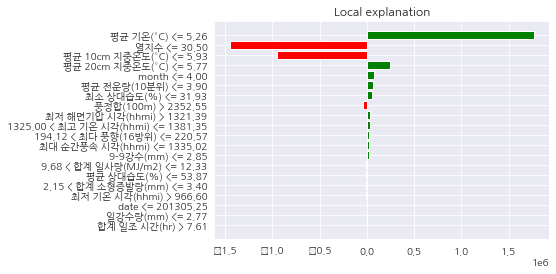

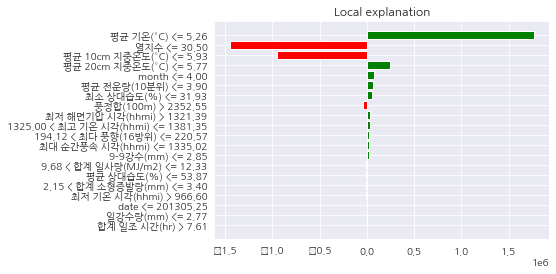

In [ ]:
exp=explainer.explain_instance(x_test.iloc[0], reg_all.predict, num_features=len(x_train.columns))
plt.rcParams['font.family'] = 'NanumGothic'
exp.as_pyplot_figure()

In [ ]:
exp.show_in_notebook(show_table=True, show_all=False)

positive로 분류가 되어있는 내용

In [ ]:
columns=pd.DataFrame(exp.as_list(), columns=['name','value'])

In [ ]:
columns.loc[columns['value']>=0] # 긍정적인 영향을 주는 칼럼만 남김

,name,value
0,평균 기온(°C) <= 5.26,1.768903e+06
3,평균 20cm 지중온도(°C) <= 5.77,2.438312e+05
4,month <= 4.00,7.131593e+04
5,평균 전운량(10분위) <= 3.90,6.249085e+04
6,최소 상대습도(%) <= 31.93,5.702555e+04
8,최저 해면기압 시각(hhmi) > 1321.39,3.870494e+04
9,1325.00 < 최고 기온 시각(hhmi) <= 1381.35,3.126307e+04
10,194.12 < 최다 풍향(16방위) <= 220.57,2.583094e+04
11,최대 순간풍속 시각(hhmi) <= 1335.02,2.360383e+04
12,9-9강수(mm) <= 2.85,2.229460e+04


평균 기온

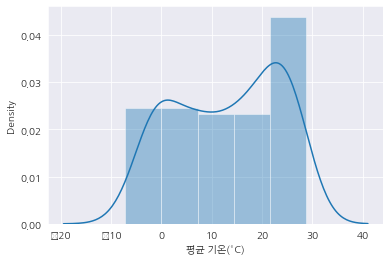

In [ ]:
plt.rcParams['font.family'] = 'NanumGothic' 
sns.distplot(df_seoul['평균 기온(°C)'])

- 쌍곡분포 같은 경우는 비닝해주거나 가우시안 믹스처 모델 활용 (단, 정규분포라는 가정 성립해야 함.)

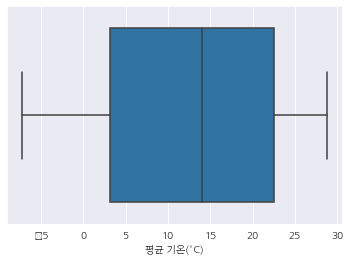

In [ ]:
plt.rcParams['font.family'] = 'NanumGothic'
sns.boxplot(x = '평균 기온(°C)', orient = "v", data = df_seoul)
sns.set_style("darkgrid")
plt.show()

샤프로 재확인

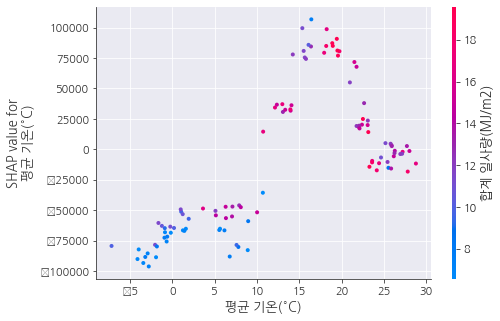

In [ ]:
plt.rcParams['font.family'] = 'NanumGothic'
shap.dependence_plot('평균 기온(°C)', shap_values, x)

열지수

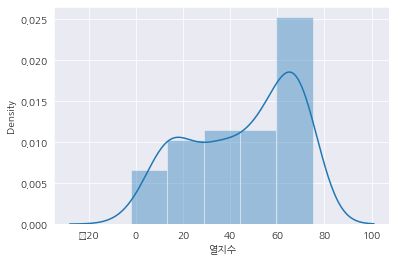

In [ ]:
plt.rcParams['font.family'] = 'NanumGothic' 
sns.distplot(df_seoul['열지수'])

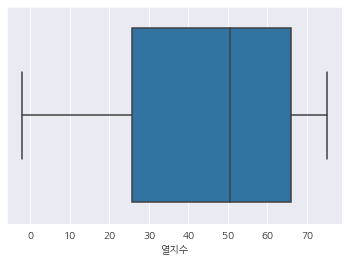

In [ ]:
plt.rcParams['font.family'] = 'NanumGothic'
sns.boxplot(x = '열지수', orient = "v", data = df_seoul)
sns.set_style("darkgrid")
plt.show()

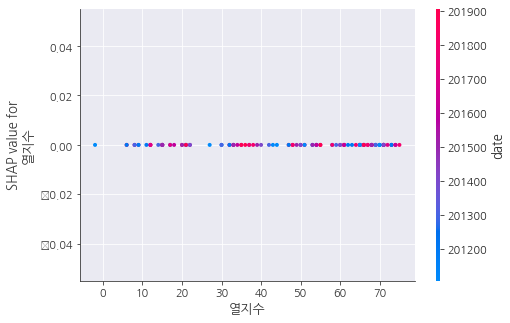

In [ ]:
plt.rcParams['font.family'] = 'NanumGothic'
shap.dependence_plot('열지수', shap_values, x)

시간 관계상 경복궁 2탄은 여기서 마무리 짓고
--
다음에 더 자세히 분석해보기로 한다.
--